## Elisa Malzoni e Bruna Kimura

In [1]:
%reset -f
# %matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Projeto 1-2: Restauração de uma imagem de sinalização de trânsito

Você está trabalhando em um projeto da nova versão do PatoPatoVai Street View. Seu objetivo é melhorar a qualidade das imagens obtidas pela câmera do veículo, especialmente em relação ao *motion blur* (pois a câmera está fixada no carro, e os solavancos da estrada podem resultar em borramento das imagens capturadas).

Considere a imagem abaixo:

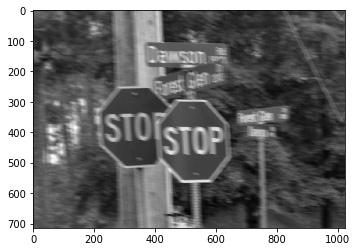

In [2]:
img_blur = cv2.cvtColor(cv2.imread('blur.png'), cv2.COLOR_BGR2GRAY) / 255.0

# plt.figure(figsize=(10, 8))
plt.imshow(img_blur, cmap='gray');

Está difícil saber a que altura da rua Forest Glen estamos. Sua equipe está desenvolvendo um primeiro protótipo de um sistema que, a partir desta imagem, gera uma imagem nítida e com perspectiva corrigida de cada uma das placas indicadoras da rua.

Você foi encarregado de fazer uma primeira versão do melhoramento de imagem (*deblurring*, contraste, correção de perspectiva), onde parâmetros essenciais do *deblurring* (tamanho de kernel, orientação, tipo), do contraste e da correção de perspectiva (pontos notáveis) podem ser determinados manualmente. Na sua equipe tem outros engenheiros trabalhando no problema de detectar e segmentar as placas presentes na cena. 

Para facilitar a experimentação:

- O Scikit-Image já tem uma função que faz o filtro de Wiener: ``skimage.restoration.wiener``

- Segue código para fazer um *kernel* de *motion blur* dado o tamanho do kernel, o comprimento do segmento de reta, e o ângulo.

In [3]:
from skimage.restoration import wiener

def make_psf(shape, length, angle):
    psf = np.zeros(shape)
    rows, cols = shape
    center = (cols//2, rows//2)
    psf[center[1], center[0]:(center[0]+length)] = 1.0
    M = cv2.getRotationMatrix2D(center, angle, 1)
    psf = cv2.warpAffine(psf, M, (cols, rows))
    psf = psf / psf.sum()
    return psf

## Tarefa

Escreva um programa que:

- Corrige o *motion blur*
    - Não é necessário neste projeto que o sistema escolha automaticamente os melhores parâmetros para o *deblurring*, determine-os manualmente.

- Melhora o contraste
    - Novamente, se precisar ajustar parâmetros manualmente, tudo bem. Escolha a técnica que quiser para melhoramento de contraste.
    
- Extrai a placa de rua com correção de perspectiva.
    - Os pontos dos cantos da placa não precisam ser determinados automaticamente, escolha manualmente os pontos. A outra parte da sua equipe está trabalhando no outro problema.
    

### Rubrica

- **I**: Entregou algo sem sentido ou muito incompleto (não atinge o nível *D*)

- **D**: Entregou o projeto quase completo, mas faltaram 2 itens dentre os descritos acima.

- **C**: Entregou o projeto quase completo, mas faltou 1 item dentre os descritos acima.

- **B**: Entregou o projeto completo.

- **A**: Entregou o projeto completo e testou alguma técnica mais avançada para resolver o problema do motion-blur. Ver o artigo "Restoration of Motion-Blurred Image Based on Border Deformation Detection: A Traffic Sign Restoration Model", em anexo no Blackboard.

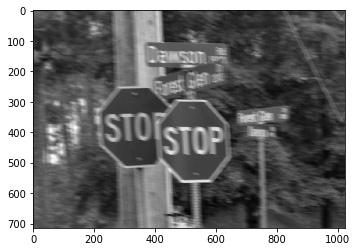

In [4]:
# %matplotlib notebook
plt.imshow(img_blur, cmap='gray')

In [5]:
def wiener1(G, H, K):
    W = H.conj() / (np.abs(H)**2 + K)
    F = W*G
    return F

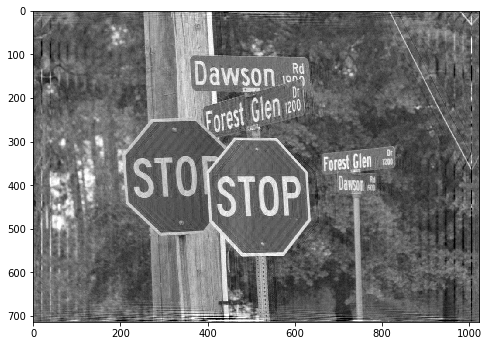

In [15]:
# Chuta o K.
K = 0.001

# Chuta o h
h = make_psf((img_blur.shape[0],img_blur.shape[1]), 20, -10)
# h = make_psf(img_test_blur.shape, 5)
H = np.fft.fft2(h)


# img_blur_recon = wiener(img_blur, h, K)

G = np.fft.fft2(img_blur)
img_test_blur_recon_wiener_freq = wiener1(G, H, K)
img_blur_recon = np.fft.fftshift(np.fft.ifft2(img_test_blur_recon_wiener_freq).real)

plt.figure(figsize=(8, 8))
plt.imshow(np.clip(img_blur_recon, 0, 1), cmap='gray');

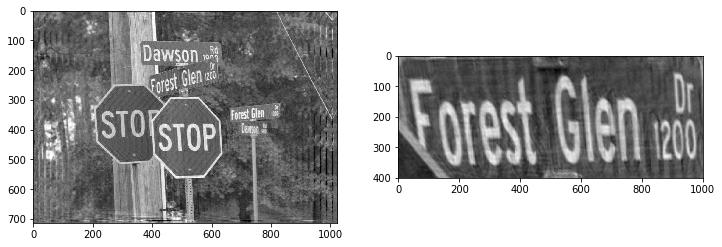

In [65]:
%matplotlib inline
rows, cols = 400, 1000

pts_original = np.float32([[389, 220], [618,158],[360,300],[673,250]])


# pts_corrigida = np.float32([[0, 0], [cols, 0], [0, rows], [rows, cols]])
pts_corrigida = np.float32([[0, 0], [cols , 0], [-100, rows - 10 ], [rows + 800, cols - 500]])

M = cv2.getPerspectiveTransform(pts_original, pts_corrigida)

img_corrigida = cv2.warpPerspective(img_blur_recon, M, (cols, rows))

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.clip(img_blur_recon, 0, 1), cmap='gray')
plt.subplot(122)
plt.imshow(img_corrigida, cmap='gray')
plt.show()

In [66]:
# #descobrindo o kernel
# def imagem(img_blur, L, o, k):
#     kernel = make_psf((31,31), L,  o)
#     img = wiener(img_blur, kernel, k)
#     return kernel, img
    

In [67]:
# length = [10, 15,20]
# angles = [-5,5,10,15]
# ks = [0.01,0.002]
# for l in length:
#     for a in angles:
#         for k in ks:
#             plt.figure(figsize=(8,6))
#             #plt.subplot(121)
#             kernel, img = imagem(img_blur, l, a, k)
#             #plt.imshow(kernel, cmap='gray')
#             plt.title("k {0}, angulo {1}, comprimento {2}".format(k, a, l))
#             #plt.subplot(122)
#             plt.imshow(img, cmap='gray')

In [68]:
#contraste clip

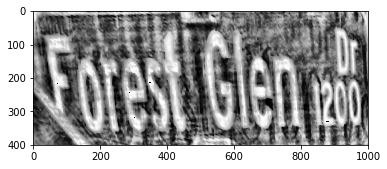

In [73]:
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10,10))
img_clahe = clahe.apply(np.array(img_corrigida*255, dtype=np.uint8))
plt.imshow(img_clahe,cmap='gray')

In [72]:
img_clip = np.clip(img_corrigida,0,1)
low = img_corrigida.min()
high = img_corrigida.max()
low, high

(0.1463669416986804, 1.0609433893449713)

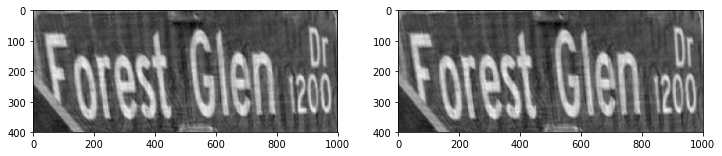

In [81]:
def dr(img, min, max):
    return np.uint8(np.clip((255/(max-min))*(img-min),0,255))
    
new_img = dr(img_corrigida, low, high)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(img_corrigida, cmap='gray')
plt.subplot(122)
plt.imshow(new_img, cmap='gray')
plt.show()